Jelle, July 2016

In [1]:
from copy import deepcopy

import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

from wimpy.xenon.base_model import config, nr_ignore_settings
from wimpy.likelihood import LogLikelihood
from wimpy.inference import one_parameter_interval

# Setup

Set up a log likelihood function for each wimp mass. This will take about 10 minutes if you've never run it before (otherwise it is very fast), so grab a cup of coffee. There are ways to use multiple cores to speed this up, but I won't go into that here.

Notice the first wimp mass takes much longer to compute than the others, asis because the PDFs for the background
sources are have to be built once (or once for each Leff in the case of NR backgrounds).

We could also have set up one likelihood function with many wimps, then turned all but one wimp on all the time, it doesn't make much difference.

In [2]:
# Dictionary to contain the likelihood functions for different wimp masses
lfs = {}
wimp_masses = [7, 10, 20, 50, 100, 200, 1000]

for m in wimp_masses:    
    print("Making likelihood function for wimp mass %d" % m)
    # Copy the base config and remove any wimps present there
    c = deepcopy(config)
    c['sources'] = [s for s in c['sources'] if not s['name'].startswith('wimp')]
    
    # Add the wimp of this mass
    c['sources'].append({
        'energy_distribution': 'wimp_%dgev_1e-45cm2.csv' % m,
        'color': 'red',
        'recoil_type': 'nr',
        'name': 'wimp_%dgev' % m,
        'n_events_for_pdf': 5e6,
        'ignore_settings': nr_ignore_settings,
        'label': '%d GeV WIMP' % m})
    
    # Create the log likelihood function
    lf = LogLikelihood(c)
    lf.add_rate_parameter('wimp_%dgev' % m)
    lf.add_shape_parameter('leff', 
                           {t: 'leff_mcpaper_%s.csv' % t for t in [-2, -1, 0, 1, 2]}, 
                           log_prior=stats.norm.logpdf)
    lf.prepare()
    
    # Store it in the dictionary
    lfs[m] = lf

Making likelihood function for wimp mass 7


Making likelihood function for wimp mass 10


Making likelihood function for wimp mass 20


Making likelihood function for wimp mass 50


Making likelihood function for wimp mass 100


Making likelihood function for wimp mass 200


Making likelihood function for wimp mass 1000


# Simulate/load background data

Let's simulate some background datasets.

In [55]:
n_trials = 1000
bg_dsets = [lfs[50].base_model.simulate(rate_multipliers=dict(wimp_50gev=0)) 
            for _ in tqdm(range(n_trials))]

Here is one background dataset:

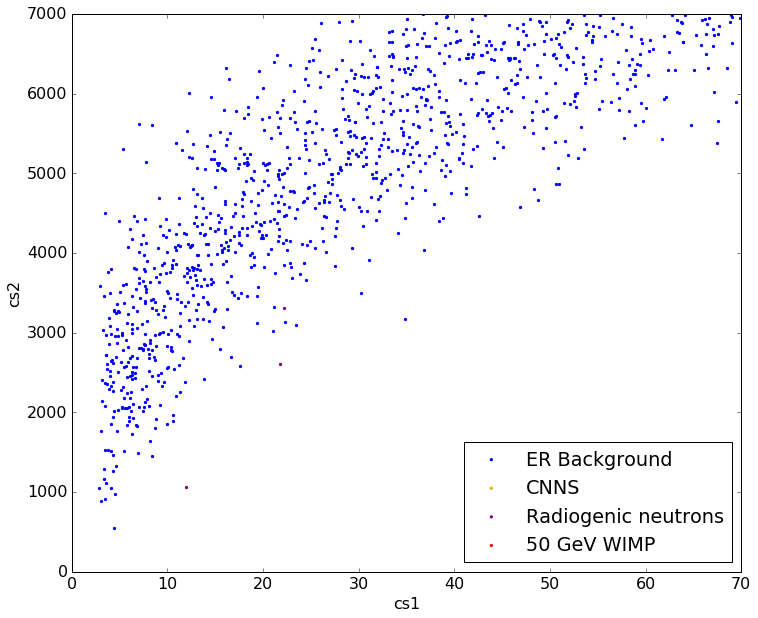

In [67]:
d = bg_dsets[34]
lf = lfs[50]
lf.base_model.show(d)
plt.legend(loc='lower right', scatterpoints=1)

Let's see what the log likelihood function (for a 50 GeV WIMP) thinks of this:

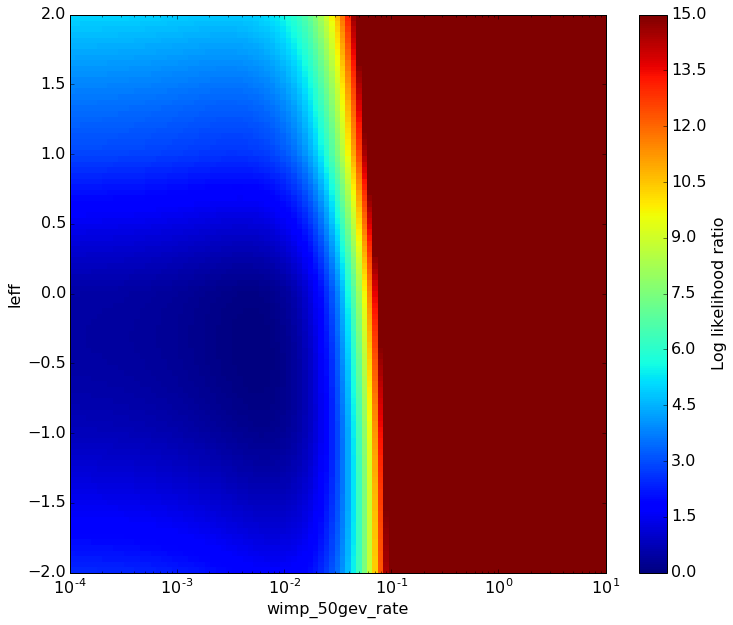

In [68]:
from wimpy.analysis import plot_likelihood_ratio
lf.set_data(d)
plot_likelihood_ratio(lf, ('wimp_50gev_rate', np.logspace(-4, 1, 100)), ('leff', np.linspace(-2, 2, 100)))
plt.xscale('log')

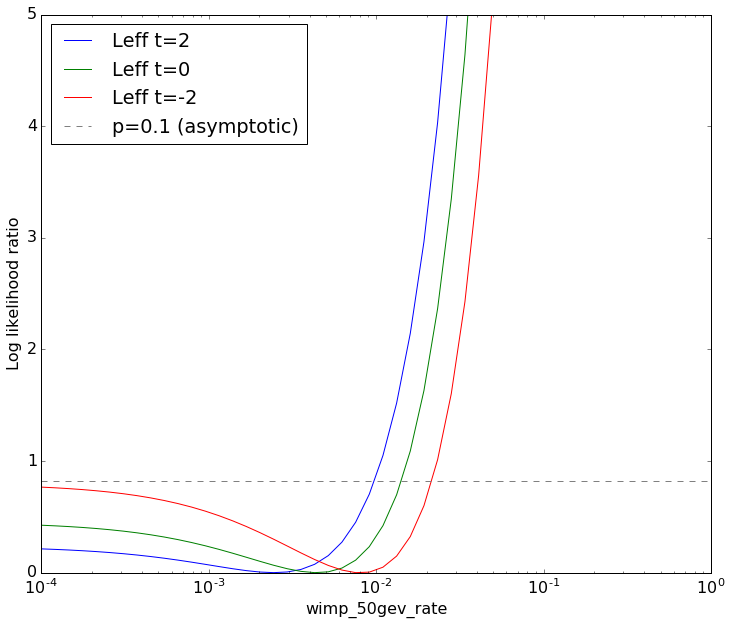

In [77]:
from wimpy.analysis import plot_likelihood_ratio

base_rate = lf.base_model.get_source('wimp_50gev').events_per_day

for leff in [2, 0, -2]:
    plot_likelihood_ratio(lf, ('wimp_50gev_rate', np.logspace(-4, 0, 50)), leff=leff, 
                          plot_kwargs=dict(label="Leff t=%s" % leff), vmax=5)

plt.axhline(stats.norm.ppf(0.9)**2/2, linestyle='--', label='p=0.1 (asymptotic)', c='gray')
plt.xscale('log')
plt.legend(loc='upper left')

Allright, let's let loose on all the background datasets. This will take a long time as well, if you don't have a lot of time leave out the profile likelihood lines (the try-except block at the end).

In [44]:
limits_lr = {m: np.zeros(n_trials) for m in wimp_masses}
limits_plr = {m: np.zeros(n_trials) for m in wimp_masses}
limits_lr_lowleff = {m: np.zeros(n_trials) for m in wimp_masses}

for m in wimp_masses:
    print("Computing limits for wimp mass %d GeV" % m)
    lf = lfs[m]
    scale = lfs[m].base_model.sources[-1].events_per_day / 1e-45
    
    for i, d in enumerate(tqdm(bg_dsets)):
        lf.set_data(d)
        target = 'wimp_%dgev_rate' % m
        limits_lr[m][i] = one_parameter_interval(lf, target, bound=100, kind='upper', leff=0) / scale
        limits_lr_lowleff[m][i] = one_parameter_interval(lf, target, bound=100, kind='upper', leff=-2) / scale
        try:
            limits_plr[m][i] = one_parameter_interval(lf, target, bound=100, kind='upper') / scale
        except Exception as e:
            print("Failure in limit setting for dataset %d, %d GeV: %s, %s" % (i, m, str(type(e)), str(e)))

Computing limits for wimp mass 7 GeV


  2%|▉                                                 | 18/1000 [00:08<05:32,  2.95it/s]C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


Computing limits for wimp mass 10 GeV


Computing limits for wimp mass 20 GeV


Computing limits for wimp mass 50 GeV


Computing limits for wimp mass 100 GeV


Computing limits for wimp mass 200 GeV


Computing limits for wimp mass 1000 GeV


In [47]:
# import pickle
# with open('lims.pkl', mode='wb') as outfile:
#     pickle.dump((limits_lr, limits_lr_lowleff, limits_plr), outfile)

Plot the median of the limits we just derived, and the bands for the profiled limits. We also plot the Bologna model noCLS limit for comparison:

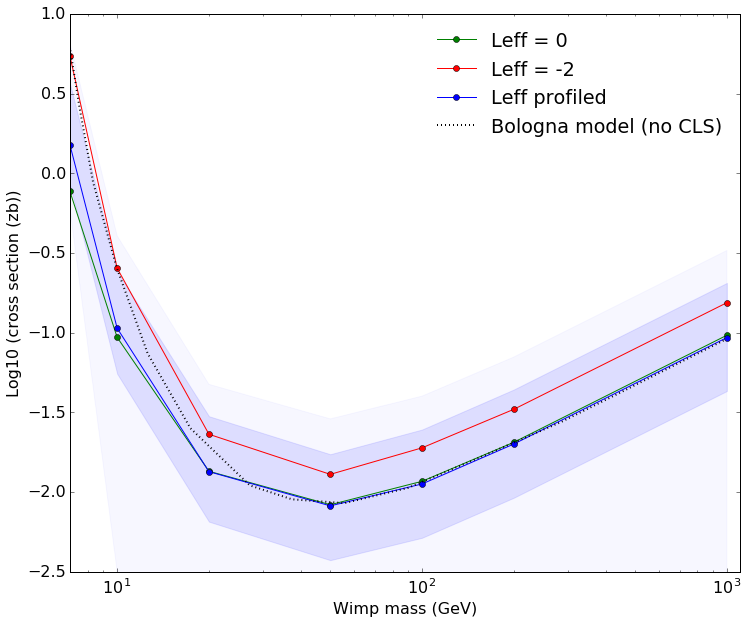

In [53]:
for limit_dict, label, color in ((limits_lr, 'Leff = 0', 'g'),
                                 (limits_lr_lowleff, 'Leff = -2', 'r'),
                                 (limits_plr, 'Leff profiled', 'b')
                                ):
    limits_sigma = {sigma: np.array([np.percentile(np.log10(limit_dict[m]) + 45, 100*stats.norm.cdf(sigma)) 
                                     for m in wimp_masses])
                    for sigma in [-2, -1, 0, 1, 2]}
    plt.plot(wimp_masses, limits_sigma[0], 
             marker='o', color=color, label=label)
    if color == 'b':
        plt.fill_between(wimp_masses, limits_sigma[-1], limits_sigma[1], alpha=0.1, color=color)
        plt.fill_between(wimp_masses, limits_sigma[-2], limits_sigma[2], alpha=0.03, color=color)

# Load the Bologna model data points
ms, xs = pd.read_csv('./bologna_nocls_limits/median_nocls.csv', skiprows=5, names=['m', 'xs'])[1:].values.astype(np.float).T
plt.plot(ms, xs + 45, color='k', linestyle=':', label='Bologna model (no CLS)', linewidth=2)
        
plt.xscale('log')
plt.legend(loc='upper right', numpoints=1, frameon=False)
plt.xlim(7, 1100)
plt.ylim(-2.5, 1)
plt.xlabel("Wimp mass (GeV)")
plt.ylabel("Log10 (cross section (zb))")
plt.show()

At high masses we have a good agreement with the Bologna model. 

At low masses there are differences. A possible reason is that we only considered likelihood functions with the prior for Leff at t=0, whereas the MC paper varied the mean of the prior in each analysis (see [here](https://xecluster.lngs.infn.it/dokuwiki/doku.php?id=xenon:xenon1t:sim:notes:marco:sensitivity-profile-likelihood-treatment-nuisance-parameter#jan_approach])). If I understand the reasoning for this correctly, the idea is that we will measure Leff (indirectly) ourselves in XENON1T and expect to obtain a Leff with a similar uncertainty (but of course not exactly the same values, since there is an uncertainty).

Another notable difference is the behaviour for limits computed with a fixed Leff=-2 at high masses. In the Bologna model, changing Leff didn't affect the sensitivity at high masses at all. This is because the Bologna model is 1d (plus a Gaussian S1/S2 discrimination proxy paramater). Lowering Leff has two effects:
  * It pushes some events below threshold;
  * By lowering S1 for the same S2, it pushes WIMP events earer to the ER band.
  
Both weaken your sensitivity; the first obivously so, the second because it makes ER leakage events more likely to be interpreted as WIMP events. For high mass the first is negligible (since the spectrum is relatively flat), but the second is not.

The plot below shows how the NR median moves deeper into the ER band at lower Leff:

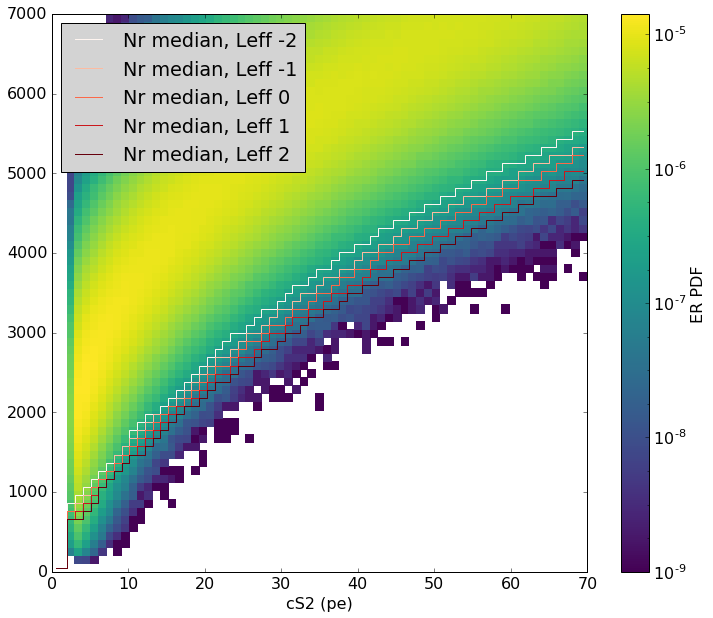

In [78]:
lf= lfs[1000]
for i, ((leff,), m) in enumerate(sorted(lf.anchor_models.items())):
    m.sources[-1].pdf_histogram.percentile(50, axis=1).plot(label='Nr median, Leff %d' % leff, color=plt.cm.Reds(i/4))
   
m.sources[0].pdf_histogram.plot(cblabel='ER PDF', log_scale=True, vmin=1e-9, cmap=plt.cm.viridis)
#m.sources[0].pdf_histogram.percentile().plot(cblabel='ER PDF', log_scale=True, vmin=1e-8, cmap=plt.cm.Blues)
leg = plt.legend(loc='upper left')
leg.get_frame().set_facecolor('lightgray')
plt.xlabel('cS1 (pe)')
plt.xlabel('cS2 (pe)')